In [1]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications.vgg16 import preprocess_input

from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
# get model
model = tf.keras.applications.VGG16(include_top=True, weights='imagenet', input_shape=(224, 224, 3))
#model.summary()

553467904/553467096 [==============================] - 4s 0us/step


(1, 600, 1500, 3)
(1, 1200, 3000, 3)


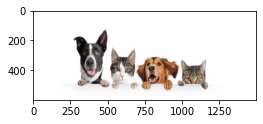

In [7]:
import matplotlib
import matplotlib.pyplot as plt

PATH = '/content/gdrive/My Drive/data/template-matching/'
height = 600
width  = 1600
image_path = PATH+'image7.jpg'

height = 600
width  = 1500
scale_level = 2
list_of_images = []

for i in range(scale_level):
  img = kimage.load_img(image_path, target_size=(height*(i+1), width*(i+1)))
  img = np.expand_dims(img, axis=0)
  list_of_images.append(img)

# check
for i in range(scale_level):
  print(list_of_images[i].shape)

plt.figure(figsize=(4,4))
plt.imshow(list_of_images[0][0])

In [10]:
# check model
for i in range(19,23):
  print(model.layers[i].name)

flatten
fc1
fc2
predictions


In [11]:
def compute_features(data):
  for i in range(1,19):
    data = model.layers[i](data)
  return data

In [12]:
def compute_prediction(data):
  for i in range(19,23):
    data = model.layers[i](data)
  return data

In [15]:
# compute features for templates
list_of_features = []
for i in range(scale_level):
  features = preprocess_input(list_of_images[i])
  print(features.shape)
  features = compute_features(features)
  list_of_features.append(features)

# check
for i in range(scale_level):
  print(list_of_features[i].shape)

(1, 600, 1500, 3)
(1, 1200, 3000, 3)
(1, 18, 46, 512)
(1, 37, 93, 512)


In [18]:
# compute predictions
side = 7
prediction_data = []

for scale in range(scale_level):
  height_fm = list_of_features[scale].shape[1]
  width_fm  = list_of_features[scale].shape[2]
  depth_fm  = list_of_features[scale].shape[3]

  for i in range(height_fm-side+1):
    for j in range(width_fm-side+1):
      patch = list_of_features[scale][:,i:i+side,j:j+side,:]
      patch = compute_prediction(patch)
      prediction_data.append( (tf.math.reduce_max(patch[0]).numpy(), 
                               i, j, tf.math.argmax(patch[0]).numpy(), scale) )
      
print(len(prediction_data))

3177


In [20]:
def getKey(item):
    return item[0]

pred_sorted = sorted(prediction_data, key=getKey, reverse=True)
print(pred_sorted[:3])

[(0.9574404, 22, 39, 283, 1), (0.938423, 23, 39, 283, 1), (0.9351347, 24, 38, 283, 1)]


In [21]:
labels = np.load(PATH+'imagenet1000_clsid_to_human.pkl', allow_pickle=True)
print(type(labels))
print(labels[227])

<class 'dict'>
kelpie


In [22]:
from scipy.spatial import distance
a = (1, 2)
b = (4, 5)
dst = distance.euclidean(a, b)
print(dst)

4.242640687119285


In [23]:
def check_duplication(i,j,data):
  result = False

  coord1 = (i,j)
  
  length = len(data)
  for k in range(length):
    coord2 = (data[k][1], data[k][2])
    dst = distance.euclidean(coord1, coord2)

    if (dst < 5):
      result = True
      break
  
  return result

In [24]:
from scipy.spatial import distance

# remove duplication
def remove_duplication(data):
  result = []

  length = len(data)
  for k in range(length-1):
    duplicated = check_duplication(data[k][1], data[k][2], result)
    
    if (duplicated==False and data[k][0]>0.5):
      result.append( data[k] )
    
    
  return result

In [26]:
print(len(pred_sorted))
print(pred_sorted[:3])
result = remove_duplication(pred_sorted)
print(len(result))
print(result[:3])

3177
[(0.9574404, 22, 39, 283, 1), (0.938423, 23, 39, 283, 1), (0.9351347, 24, 38, 283, 1)]
21
[(0.9574404, 22, 39, 283, 1), (0.8178097, 25, 63, 281, 1), (0.81386703, 27, 31, 283, 1)]


0.9574404 2
0.938423 2
0.9351347 2
0.93395257 2
0.9275586 2
0.9185956 2
0.90991527 2
0.89984965 2
0.8973495 2
0.88262165 2
0.8560192 2
0.8178097 2
0.81386703 2
0.80934864 2
0.8060877 1
0.8057645 1
0.80386335 2
0.80300474 2


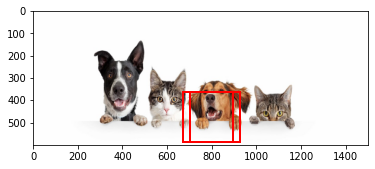

In [36]:
# Show all with a threshold
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

im = kimage.load_img(image_path, target_size=(height, width))

fig, ax = plt.subplots()
ax.imshow(im)

length = len(pred_sorted)

# Create a Rectangle patch
scale_height = height//18
scale_width  = width//46
for i in range(length): 
  if (pred_sorted[i][0] > 0.8):
    print(pred_sorted[i][0], pred_sorted[i][4]+1)
    rect = patches.Rectangle((pred_sorted[i][2]*scale_width, pred_sorted[i][1]*scale_height), 
                             224//(pred_sorted[i][4]+1), 224//(pred_sorted[i][4]+1), 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    #plt.text(pred_sorted[i][2]*scale_width-100, pred_sorted[i][1]*scale_height, labels[pred_sorted[i][3]])

plt.show()

0.9574404 22 39 1
0.8178097 25 63 1
0.81386703 27 31 1
0.8060877 11 22 0


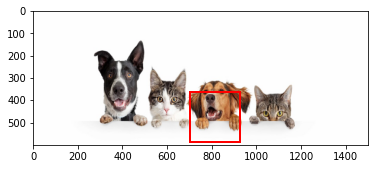

In [45]:
# Show all with a threshold
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

im = kimage.load_img(image_path, target_size=(height, width))

fig, ax = plt.subplots()
ax.imshow(im)

length = len(result)

# Create a Rectangle patch
scale_height = height//18
scale_width  = width//46
for i in range(length):
  if (result[i][0] > 0.8):
    print(result[i][0], result[i][1], result[i][2], result[i][4])
    rect = patches.Rectangle((result[i][2]*scale_width,result[i][1]*scale_height), 
                             224//(result[i][4]+1), 224//(result[i][4]+1), 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    #plt.text(result[i][2]*scale_width-100, result[i][1]*scale_height, labels[result[i][3]])

plt.show()